Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Entropy: 0.999926399368686
Gini Index: 0.49994898479746963
Best Root Node Feature Index: 412


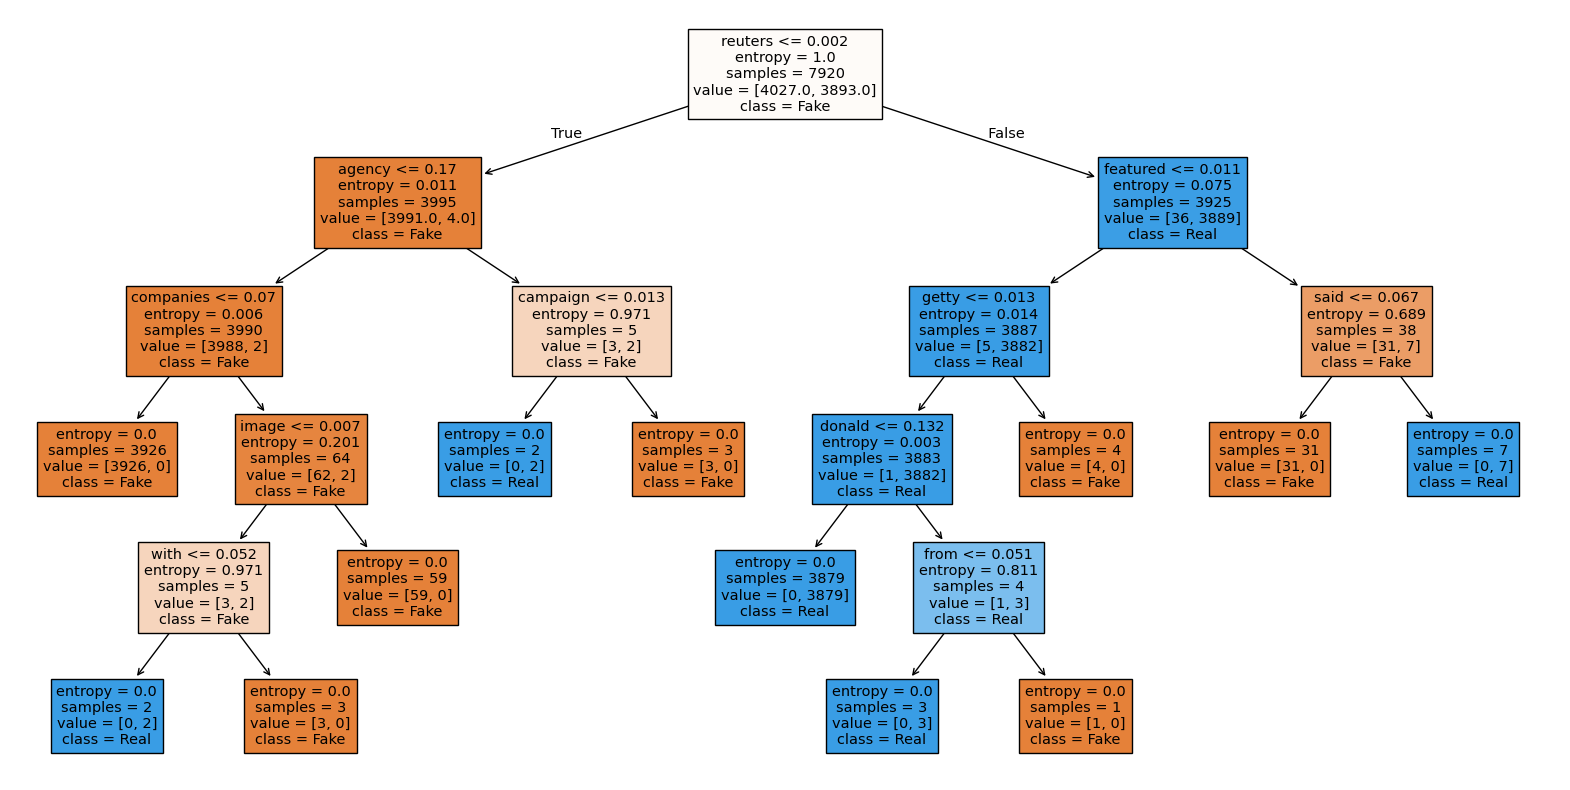

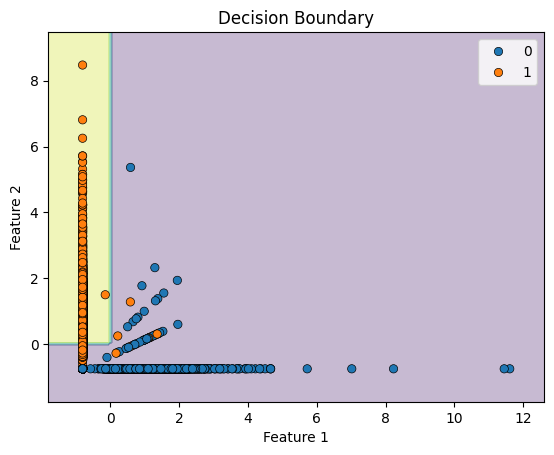

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/fake_and_real_news.csv'
df = pd.read_csv(file_path)

def calculate_entropy(y):
    """Calculate entropy of class labels."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def calculate_gini(y):
    """Calculate Gini index of class labels."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

def information_gain(X, y):
    """Calculate information gain for each feature and return the best feature index."""
    base_entropy = calculate_entropy(y)
    info_gains = []

    for i in range(X.shape[1]):
        values, counts = np.unique(X[:, i], return_counts=True)
        weighted_entropy = sum((counts[j] / len(y)) * calculate_entropy(y[X[:, i] == values[j]]) for j in range(len(values)))
        info_gains.append(base_entropy - weighted_entropy)

    return np.argmax(info_gains)

def preprocess_text_data(df):
    """Convert text into TF-IDF features."""
    if 'Text' not in df.columns:
        raise ValueError("Column 'Text' not found. Check dataset headers.")

    vectorizer = TfidfVectorizer(max_features=500)
    X = vectorizer.fit_transform(df['Text']).toarray()
    y = df['label'].map({'Fake': 0, 'Real': 1}).values
    return X, y, vectorizer

def train_decision_tree(X, y):
    """Train a Decision Tree classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    return clf, X_train, X_test, y_train, y_test

def visualize_decision_tree(clf, vectorizer):
    """Visualize the trained Decision Tree."""
    plt.figure(figsize=(20,10))
    plot_tree(clf, feature_names=vectorizer.get_feature_names_out(), class_names=['Fake', 'Real'], filled=True)
    plt.show()

def select_top_two_features(X, y):
    """Select top two features based on feature importance."""
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    top_two_indices = np.argsort(feature_importances)[-2:]
    return X[:, top_two_indices], top_two_indices

def train_decision_tree_top_features(X, y):
    """Train a decision tree with only the top two selected features."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    return clf, X_train, X_test, y_train, y_test

def visualize_decision_boundary(X, y, clf):
    """Visualize decision boundary for two selected features."""
    if X.shape[1] != 2:
        print("Error: Need exactly two features to plot decision boundary.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y, edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

# Load and process dataset
X, y, vectorizer = preprocess_text_data(df)

# Compute entropy and Gini index
print(f'Entropy: {calculate_entropy(y)}')
print(f'Gini Index: {calculate_gini(y)}')

# Select root node using information gain
best_feature_idx = information_gain(X, y)
print(f'Best Root Node Feature Index: {best_feature_idx}')

# Train and visualize full decision tree
clf, X_train, X_test, y_train, y_test = train_decision_tree(X, y)
visualize_decision_tree(clf, vectorizer)

# Select top two features and train a new decision tree
X_selected, top_indices = select_top_two_features(X, y)
clf_selected, X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_decision_tree_top_features(X_selected, y)

# Visualize decision boundary
visualize_decision_boundary(X_selected, y, clf_selected)
